# Phi3 Chain-ofThought Inference



In [1]:
#val_or_test_split = 'val'
val_or_test_split = 'test'

In [2]:
!pip install -q transformers datasets sentencepiece accelerate evaluate tiktoken einops flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 73.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 90.8 MB/s eta 0:00:00
ERROR:

In [3]:
from datasets import load_dataset

hf_site_id = '2024-mcm-everitt-ryan'
dataset_id = f'{hf_site_id}/job-bias-synthetic-human-benchmark-v2'

dataset = load_dataset(dataset_id)
print(dataset)
column_names = dataset['train'].column_names

text_col = 'text'
label_cols = [col for col in column_names if col.startswith('label_')]

labels = [label.replace("label_", "") for label in label_cols]

id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

# Remove all columns apart from the two needed for multi-class classification
keep_columns = ['context_id', 'synthetic', text_col] + label_cols
dataset = dataset[val_or_test_split].remove_columns(
    [col for col in dataset[val_or_test_split].column_names if col not in keep_columns])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Generating train split:   0%|          | 0/4609 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/593 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/584 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'label_age', 'analysis_age', 'label_disability', 'analysis_disability', 'label_feminine', 'analysis_feminine', 'label_general', 'analysis_general', 'label_masculine', 'analysis_masculine', 'label_neutral', 'analysis_neutral', 'label_racial', 'analysis_racial', 'label_sexuality', 'analysis_sexuality', 'verified', 'synthetic', 'text', 'metadata'],
        num_rows: 4609
    })
    val: Dataset({
        features: ['id', 'label_age', 'analysis_age', 'label_disability', 'analysis_disability', 'label_feminine', 'analysis_feminine', 'label_general', 'analysis_general', 'label_masculine', 'analysis_masculine', 'label_neutral', 'analysis_neutral', 'label_racial', 'analysis_racial', 'label_sexuality', 'analysis_sexuality', 'verified', 'synthetic', 'text', 'metadata'],
        num_rows: 593
    })
    test: Dataset({
        features: ['id', 'label_age', 'analysis_age', 'label_disability', 'analysis_disability', 'label_feminine', 'analy

# Prompt Formatting & Data preprocessing

Inspiration from https://medium.com/@olaf.lenzmann/mastering-llms-for-complex-classification-tasks-64f0bda2edf3

In [4]:
system = "You are an analyst of job postings.\n"
instruction = "Your job is to analyse a job posting and determine if it contains implicit bias towards or against certain groups. The bias categories are age, disability, feminine, masculine, racial, sexuality, general, neutral. Return the appropriate label only when absolutely sure that the particular bias category is present in the text.\n"
closing_instruction = "Does the job posting contain any implicit bias? Please respond in the format of 'Labels: <labels>' where the possible labels are zero or more from the choices of age, disability, feminine, masculine, racial, sexuality, general. If no biased language is present, please return zero labels. No further explanation is required."

cot = """
Think step by step to determine if there is implicit bias present in the job posting.
Step 1: Check for age bias.
Step 2: Check for disability bias.
Step 3: Check for feminine bias.
Step 4: Check for masculine bias.
Step 5: Check for racial bias.
Step 6: Check for sexuality bias.
Step 7: Check for general bias - bias other than the previous bias categories.
"""
def construct_prompt_cot (query_job_description):
    evidence = f"Job Posting: \n {query_job_description} \n ===END=== \n"
    content = system + instruction + cot + evidence + closing_instruction
    messages = [{"role": "user", "content": content}]
    return messages

In [5]:
def get_formatted_prompt(job_description):
    msgs = construct_prompt_cot(job_description)
    return msgs

In [6]:
import numpy as np

def preprocess_data(sample):
    # take a batch of texts
    text = sample[text_col]
    sample['prompt'] = list(map(get_formatted_prompt, sample[text_col]))
    # add labels
    labels_batch = {k: sample[k] for k in sample.keys() if k in label_cols}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(label_cols)), dtype=int)
    # fill numpy array
    for idx, label in enumerate(label_cols):
        labels_matrix[:, idx] = labels_batch[label]

    sample["labels"] = labels_matrix.tolist()
    return sample

# Label extraction

In [7]:
import re

def extract_labels(text):
    # Define the regular expression pattern to capture the needed parts
    pattern = r'\bLabels: \s*(?P<labels>[^\.]+)'

    # Search the text for matches
    match = re.search(pattern, text, re.DOTALL)

    if match:
        # Extract the 'answer' part and split it into a list of words
        answer_list = match.group('labels').split(', ')
        return answer_list
    else:
        return None

def responses_to_predictions(responses):
    #Extract labels
    label_set = set(labels) # Just for efficiency
    predictions = []
    not_parsed = []
    for i, res in enumerate(responses):
        for seq in res:
            predicted = np.zeros((len(labels),), dtype=int)
            generated_text = seq['generated_text']

            words_list = extract_labels(generated_text)
            if words_list is not None:
                for idx, l in enumerate(labels):
                    if l in words_list:
                        predicted[idx] = 1

                predictions.append(predicted)
            else:
                not_parsed.append(i)
    return predictions, not_parsed

processed_dataset = dataset.map(preprocess_data, batched=True, remove_columns=[col for col in dataset.column_names if col not in ['prompt','labels']])

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

# Metrics & Result display

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

# Define custom metric function
def compute_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0.0)
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0.0)
    f1_samples = f1_score(y_true=y_true, y_pred=y_pred, average='samples', zero_division=0.0)
    f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0.0)

    precision_micro = precision_score(y_true=y_true, y_pred=y_pred, average='micro')
    recall_micro = recall_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc_micro = roc_auc_score(y_true=y_true, y_score=y_pred, average='micro')
    # return as dictionary
    metrics = {
        'accuracy': accuracy,
        f'f1_micro': f1_micro,
        f'f1_macro': f1_macro,
        f'f1_samples': f1_samples,
        f'f1_weighted': f1_weighted,
        f'precision_micro': precision_micro,
        f'recall_micro': recall_micro,
        f'roc_auc_micro': roc_auc_micro}
    return metrics

# Function to calculate true positives, false positives, true negatives, and false negatives
def calculate_counts(true_labels, predicted_labels):
    tp = np.sum((true_labels == 1) & (predicted_labels == 1), axis=0)
    fp = np.sum((true_labels == 0) & (predicted_labels == 1), axis=0)
    tn = np.sum((true_labels == 0) & (predicted_labels == 0), axis=0)
    fn = np.sum((true_labels == 1) & (predicted_labels == 0), axis=0)
    return tp, fp, tn, fn

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def print_metrics(metrics):
    print("Evaluation Metrics:")
    print("===================")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').capitalize():<20}: {value:.4f}")

def heatmap_TP_FP_TN_FN(tp, fp, tn, fn):
    data = {
        'True Positive': tp,
        'False Positive': fp,
        'True Negative': tn,
        'False Negative': fn
    }

    df = pd.DataFrame(data, index=labels)

    # Plot the data using seaborn
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.T, annot=True, cmap='Blues', fmt='d', linewidths=.5)
    plt.title('Multi-Label Confusion Matrix Breakdown by Class')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.show()

# Model, Tokenizer & Pipeline

In [ ]:
# Load the model and tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "microsoft/Phi-3-small-8k-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)

model.half() #this is needed if GPU ram is less than approx 26gb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


In [11]:
from transformers import pipeline
import torch

pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, torch_dtype=torch.float16, device_map=device)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# Run Inference - Validation or Test

/root/.cache/huggingface/modules/transformers_modules/microsoft/Phi-3-small-8k-instruct/69caae1f2acea34b26f535fecb1f2abb9a304695/triton_flash_blocksparse_attn.py:88: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  x = [xi.to_sparse_csr() for xi in x]


Num not parsed: 0
Evaluation Metrics:
Accuracy            : 0.4709
F1 micro            : 0.5723
F1 macro            : 0.5869
F1 samples          : 0.5845
F1 weighted         : 0.5869
Precision micro     : 0.5470
Recall micro        : 0.6000
Roc auc micro       : 0.7606


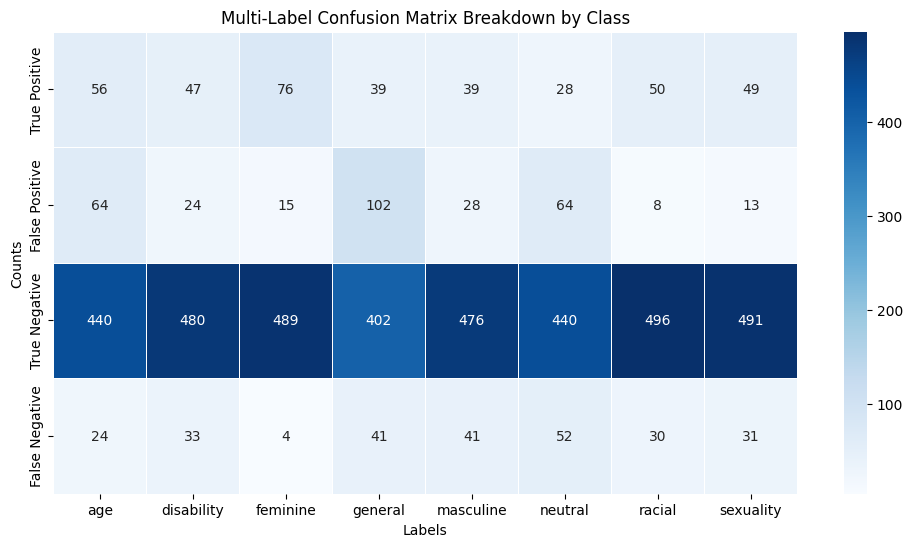

              precision    recall  f1-score   support

         age       0.47      0.70      0.56        80
  disability       0.66      0.59      0.62        80
    feminine       0.84      0.95      0.89        80
     general       0.28      0.49      0.35        80
   masculine       0.58      0.49      0.53        80
     neutral       0.30      0.35      0.33        80
      racial       0.86      0.62      0.72        80
   sexuality       0.79      0.61      0.69        80

   micro avg       0.55      0.60      0.57       640
   macro avg       0.60      0.60      0.59       640
weighted avg       0.60      0.60      0.59       640
 samples avg       0.57      0.63      0.58       640



In [12]:
from transformers.utils import logging
from sklearn.metrics import classification_report

# The following warning message is being logged for every batch, despite the fact that padding_side is set to 'left'. Does not seem to be affecting results so hide the warning
# "A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer."
#logging.get_logger("transformers").setLevel(logging.ERROR)

# Uncomment to test a subset
#num_tests=10
#data_to_test = processed_dataset.select(range(num_tests))
data_to_test = processed_dataset

responses = pipeline(data_to_test['prompt'],
                     max_new_tokens=500,
                     return_full_text=False,
                     do_sample=False
                     )

#Extract labels
label_set = set(labels) # Just for efficiency
predictions, not_parsed = responses_to_predictions(responses)

print(f"Num not parsed: {len(not_parsed)}")

#There still may be a few unparseable responses. Remove these from the ground truth labels
#In testing, there are zero unparseable, so this could be removed. Results are valid
truth_labels = data_to_test['labels']
filtered_truth_labels = [label for idx, label in enumerate(truth_labels) if idx not in not_parsed]

print_metrics(compute_metrics(predictions, filtered_truth_labels))

tp, fp, tn, fn = calculate_counts(np.array(filtered_truth_labels), np.array(predictions))
heatmap_TP_FP_TN_FN(tp, fp, tn, fn)

print(classification_report(filtered_truth_labels, predictions, target_names=labels, zero_division=0.0))

In [13]:
#responses